<a href="https://colab.research.google.com/github/camoalon/language_genes/blob/master/phonemes_PCCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can we know where a language is spoken just by hearing how it sounds?

In this notebook we use data from [Creanza et al.](https://www.pnas.org/content/112/5/1265) to try to find an answer to this question. First, we reproduce some results from [Creanza et al](https://www.pnas.org/content/112/5/1265). Then we work with a subset of the data to perform an alternative analysis with the PCCA method presented in [Brown et al](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841). We are able to get an interesting cluster structure according to geography as well as to draw some information about the distinguishing phonemes in the different clusters.

# Import packages and data

In [1]:
#@title Import  Python packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title ## Define Procrustes 
#@markdown The Procrustes transformation implemented as [scipy.spatial.procrustes](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.spatial.procrustes.html) did not seem to provide a correct result, so we decided to use the Matlab implementation of Procrustes translated to Python syntax (see [here](https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy) for details). The given procrustes function is defined below.
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

## Import data from Github

The data is stored on a public Github repository. We first clone the repositoy into the server and then read the .txt files to appropriately save the relevant data into variables.

In [3]:
#@title Load the data into the server
! git clone https://github.com/camoalon/language_genes.git

Cloning into 'language_genes'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 182 (delta 75), reused 43 (delta 14), pack-reused 0
Receiving objects: 100% (182/182), 24.32 MiB | 10.23 MiB/s, done.
Resolving deltas: 100% (75/75), done.


###Read the data of the PNAS paper
These are the supplementary data published together with [Creanza et al](https://www.pnas.org/content/112/5/1265). They are only the data corresponding with the phonemes in the Ruhlen database as no data about the PHOIBLE or the alleles could be found as suplementary material of the paper. 

In [4]:
% cd language_genes/data/PNAS

/content/language_genes/data/PNAS


In [5]:
paper = pd.read_csv('pnas.1424033112.sd01.txt', skiprows = 17, sep = "\t", header = None)

coordinates_paper = paper.iloc[:,7:9]
phonemes_paper = paper.iloc[:,9:737]
continents_paper = paper[6]

languages_info_paper = phonemes_paper.copy()
languages_info_paper["Continents"] = continents_paper

paper2 = pd.read_csv('pnas.1424033112.sd02.txt', skiprows = 16, sep = "\t", header = None)

labels_phonemes_paper = paper2[1]
position_phonemes_paper = paper2[0]

phonemes_info_paper = pd.DataFrame([position_phonemes_paper,labels_phonemes_paper]).T

###Read the data from Nicole's email

These are the data that Lior sent to me in a forwaded email. I assume these are just a subset of the actual data in the paper. 

In [6]:
% cd ..

/content/language_genes/data


In [7]:
phonemes = pd.read_csv('Phonemes139forShannon.txt',sep='\t',header=None)
phonemes.drop(139,axis=1,inplace=True)
phonemes.index = labels_phonemes_paper

alleles = pd.read_csv('AlleleFrequencies_139forShannon.txt',sep='\t',header=None)
alleles.drop(139,axis=1,inplace=True)

coordinates = pd.read_csv('LongLat_Unscaled_139forShannon.txt',sep='\t',header=None)
coordinates.drop(139,axis=1,inplace=True)

languages = pd.read_csv('Names_139forShannon.txt',sep='\t')

Since in these data we do not have the continent for each set of phonemes/alleles but we do have the language name, we can extract the corresponding continents by reading the data provided in the supplementary material of the paper. 

In [8]:
languages_names = np.array(languages["Language name"])

continents = np.empty(len(languages_names),dtype="U25")

for index,elements in enumerate(languages_names):
  lang = elements[:-1]
  continents[index] = paper.loc[paper[1] == lang][6].values[0]

# Replicate data from PNAS paper
We start by replicating the analysis that led to Figure 1B (PCA on the Ruhlen database) in [Creanza et al.](https://www.pnas.org/content/112/5/1265) to verify that the steps followed in this script are consistent with the paper. Only data from the Ruhlen database were provided, but this is enough to verify that the analysis done in this script matches the one in the paper. 

In [9]:
# Perform PCA on the data 
pca = PCA()
pca_data = pca.fit_transform(phonemes_paper)
phonemes_paper_pc = pd.DataFrame([pca_data[:,0], pca_data[:,1]]).T

print("Explained variance of the first principal component: " + str(np.round(pca.explained_variance_ratio_[0]* 100, decimals=1)) + '%')
print("Explained variance of the second principal component: " + str(np.round(pca.explained_variance_ratio_[1]* 100, decimals=1)) + '%')

Explained variance of the first principal component: 7.8%
Explained variance of the second principal component: 7.1%


The explained variance result (PC1 $7.8$%, PC2 $7.1$%) matches exactly the result in Fig. S1A in the supplementary material of [Creanza et al.](https://www.pnas.org/content/112/5/1265).

In [10]:
# Perform Procrustes analysis on the first two principal components
d_paper, Z_paper, t_paper = procrustes(coordinates_paper.values, phonemes_paper_pc.values)

t0 = np.sqrt(1-d_paper)
print("The similarity statistic is " + str(np.round(t0, decimals=2)))

result_paper = pd.DataFrame(Z_paper)
result_paper['Continents'] = continents_paper
result_paper.columns = ['Latitude','Longitude','Continents']

The similarity statistic is 0.37


The similarity statistic result $t_0$ obtained ($0.37$) differs significantly from the one in Fig. 1B in [Creanza et al.](https://www.pnas.org/content/112/5/1265), where the similarity statistic $t_0$ was reported to be $0.57$. It is worth noting that  the range in the x-axis does not match the one in Fig. 1B either. This suggests that the coordinates reported in the supplementary data and the ones used in the analysis for the paper differ by some constant (as is also suggested by Nicole's email on the scaled vs unscaled coordinates). This slight modification can be the cause of discrepancy observed in the value of the similarity statistic. For this reason, given that the clustering structure is identical (except for the positioning) to the one in Fig. 1B in [Creanza et al.](https://www.pnas.org/content/112/5/1265), we consider the results to be reproduced and proceed our analysis.

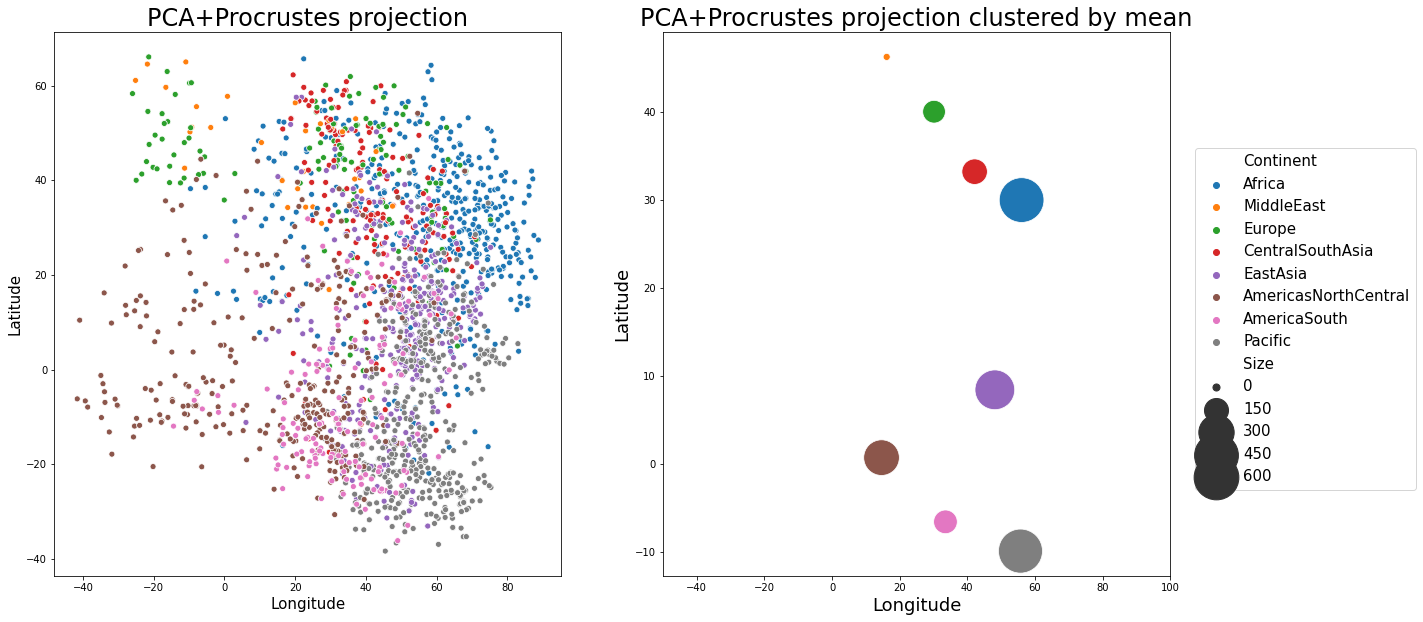

In [11]:
#@title Plot the resulting data: (A) all the points, and (B) only the clusters

# Plot the resulting data:
f, axes = plt.subplots(1, 2, sharey=False, figsize = (20,10))

# (1) with all the data points
g = sns.scatterplot(result_paper['Longitude'], result_paper['Latitude'],hue = result_paper['Continents'], legend = "brief",ax=axes[0])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize = 20)
g.set_xlabel("Longitude", fontsize = 15)
g.set_ylabel("Latitude", fontsize = 15)

#(2) with clusters (as in Nicole's paper)
labels_continents_paper = list(result_paper['Continents'].unique())
latitude_paper, longitude_paper, size_paper = np.empty(len(labels_continents_paper)), np.empty(len(labels_continents_paper)), np.empty(len(labels_continents_paper))

for i,elements in enumerate(labels_continents_paper): 
  tmp = result_paper.loc[result_paper['Continents'] == elements]
  latitude_paper[i] = np.mean(tmp['Latitude'])
  longitude_paper[i] = np.mean(tmp['Longitude'])
  size_paper[i] = len(tmp['Latitude'])

cluster_paper = pd.DataFrame([latitude_paper,longitude_paper,size_paper,labels_continents_paper]).T
cluster_paper.columns = ['Latitude','Longitude','Size','Continent']

g = sns.scatterplot(cluster_paper['Longitude'],cluster_paper['Latitude'],size=cluster_paper['Size'],hue=cluster_paper['Continent'],sizes=(50,2000),ax=axes[1])

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
xaxis = plt.xlim(-50, 100)
titl1 = axes[0].set_title("PCA+Procrustes projection", fontsize=24)
title2 = axes[1].set_title("PCA+Procrustes projection clustered by mean", fontsize=24)
xlabel = plt.xlabel("Longitude", fontsize = 18)
ylabel = plt.ylabel("Latitude", fontsize = 18)
legend = plt.legend(fontsize=15,  bbox_to_anchor=(1.5, 0.8)) # using a size in points

plt.savefig('pca_procrustes.pdf')

On the left we have the results of the PCA+Procrustes analysis, where each point represents a language and its color indicates in which continent it is spoken. On the right, the same data are represented but this time in their corresponding clusters, where each cluster (continent) is represented by a circle centered at the mean of the coordinates of the languages in the given continent and with size proportional to the number of languages in the continent. This visualization is identical to the one presented in [Creanza et al.](https://www.pnas.org/content/112/5/1265)

# Perform PCCA on the phonemes dataset using allele information
In this section we use data obtained from Nicole. This time we have phoneme information as well as allele information. We perform a PCCA analysis as described in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841), where we use allele information to find the projection for the phoneme data. No coordinate information is needed for this analysis since alleles and phonemes information can be combined directly in a single plot. 

## PCCA Method

Briefly, the PCCA method consists of performing canonical correlation analysis (CCA) on PCA projections of two datasets with registered points in high-dimensional space. The initial PCA reduces dimension to avoid overfitting by the CCA. In this case, the input consists of the allele and phoneme matrices, and the output is two different projections (one for each dataset) that are the composition of a PCA projection and a CCA map.

We start by finding the PCA projection of both the alleles and the phonemic datasets.

In [12]:
# Perform PCA on the alleles
pca = PCA()
pca_data = pca.fit_transform(alleles.T)
alleles_pca = pd.DataFrame(pca_data)

alleles_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

# Perform PCA on the phonemes
pca = PCA()
pca_data = pca.fit_transform(phonemes.T)
phonemes_pca = pd.DataFrame(pca_data)

phonemes_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
phonemes_pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
phonemes_pca_loadings.index = labels_phonemes_paper

Once the PCA projection is found, we rely in the elbow method to asses what the dimension reduction should be, i.e. how many principal components are necessasry to keep the relevant information for the further analysis. 

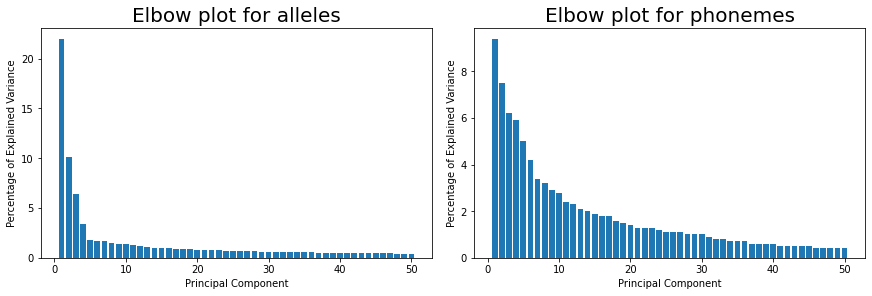

In [13]:
#@title Elbow plots to asses what the dimension reduction should be

# Plot for the alleles
fig, ax = plt.subplots(1,2, figsize=(12, 4), constrained_layout=True)
ax[0].bar(x=range(1,len(alleles_var[0:51])), height=alleles_var[0:50])
ax[0].set_ylabel('Percentage of Explained Variance', fontsize = 10)
ax[0].set_xlabel('Principal Component', fontsize = 10)
ax[0].set_title('Elbow plot for alleles', fontsize = 20)


labels_scree = [str(x) for x in range(1, len(phonemes_var)+1)]
ax[1].bar(x=range(1,len(phonemes_var[0:51])), height=phonemes_var[0:50])
ylabel = ax[1].set_ylabel('Percentage of Explained Variance', fontsize = 10)
xlabel =ax[1].set_xlabel('Principal Component', fontsize = 10)
title = ax[1].set_title('Elbow plot for phonemes', fontsize = 20)

On the left, the elbow plot for the alleles seems to suggest that 2 principal components could be a good number to keep since more than 90% of explained variance lies in the first 2 principal components. On the right, it seems like 10 principal components could be a good number to keep by the same reasoning (although this time the explained variance is more uniformly distributed).

In [14]:
# Perform the dimension reduction as informed by the elbow plots
alleles_pc = alleles_pca.iloc[:,0:2]
phonemes_pc = phonemes_pca.iloc[:,0:10]

We find the CCA projection given the phoneme and the allele dataset, and we use perform the projection on the phonemic data. 

In [15]:
# Perform CCA
n_components = 2
cca = CCA(n_components)
cca.fit(phonemes_pc,alleles_pc)
X = cca.transform(phonemes_pc)

phonemes_pcca = pd.DataFrame(X)
phonemes_pcca ['Continents'] = continents
phonemes_pcca.columns = ['C1','C2','Continents']
phonemes_cca_loadings = pd.DataFrame(getattr(cca, "x_loadings_"))

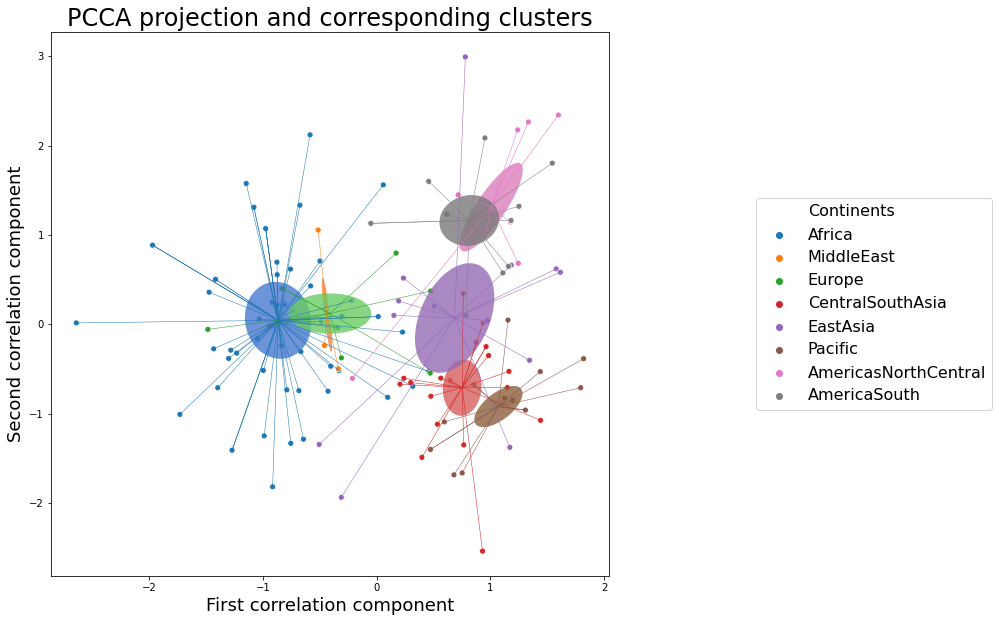

In [16]:
#@title PCCA projection of the data and their corresponding clusters
continents_unique, ind = np.unique(continents, return_index=True)
continents_unique = continents_unique[np.argsort(ind)] # to preserve its original order
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each point in the CCA projection 
ax = sns.scatterplot(phonemes_pcca['C1'], phonemes_pcca['C2'], hue = phonemes_pcca['Continents'], sizes = 15)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize = 16)

# Plot a line joining each point to the center of the cluster
for i,elements in enumerate(continents): 
  tmp = phonemes_pcca.loc[phonemes_pcca['Continents'] == elements] # choose points in a particular cluster
  center_x = np.mean(tmp["C1"]) # find the x coordinate of the center
  center_y = np.mean(tmp["C2"]) # find the y coordinate of the center
  clr = sns.color_palette()[[j for j, x in enumerate(elements == continents_unique) if x][0]] # find the color corresponding to the cluster
  plt.plot([center_x, phonemes_pcca['C1'][i]], [center_y, phonemes_pcca['C2'][i]], linewidth=.5, color = clr) # plot each line

# Plot each ellipse cluster
u = np.array([1,0])
for elements in continents_unique:

  # Take the data from a continent (2-D coordinates of the points) 
  tmp = phonemes_pcca.loc[phonemes_pcca['Continents'] == elements]

  # Compute the center of the ellipse
  center_x = np.mean(tmp["C1"])
  center_y = np.mean(tmp["C2"])
  clr = sns.color_palette("muted")[[j for j, x in enumerate(elements == continents_unique) if x][0]]

  # Do PCA on the points to find the directions of maximal variance
  pca = PCA()
  pca.fit(tmp.drop("Continents", axis = 1))

  # Find the variance on each of those directions, as well as the directions
  size = pca.explained_variance_

  if pca.components_[0][1] < 0:
    v[1] = abs(pca.components_[0][1])
    v[0] = -1*pca.components_[0][0]
  else:
    v = pca.components_[0]
  c = np.dot(u,v)/np.linalg.norm(v)
  ang = np.arccos(c)*180/np.pi

  # Draw an elipse with that orientation
  ellipse = Ellipse(xy=(center_x, center_y), width = np.sqrt(size[0]), height = np.sqrt(size[1]), angle = ang, edgecolor='None', fc=clr, alpha = 0.8)
  ax.add_patch(ellipse)

title2 = ax.set_title("PCCA projection and corresponding clusters", fontsize=24)
xlabel = ax.set_xlabel("First correlation component", fontsize = 18)
ylabel = ax.set_ylabel("Second correlation component", fontsize = 18)
plt.savefig('pcca.pdf')

The figure shows the PCCA projection of the data, where each point corresponds to a language and its color indicates the continent in which it is spoken. Each point is linked to the center of its cluster (mean of the coordinates) with a thin line. The clusters are represented this time on the same plot and using ellipses instead of circles. The ellipses are oriented in the direction of maximal variance of the cluster, and their two dimensions correspond to the standard deviation in each of both directions. 

Notice that this time the axes of the figure are simply the first and second components of the CCA projection of the data. Geographic information is already encoded through the allele information used to create the CCA projection. We believe this information was succesfully encoded given the close proximity and overlap of clusters representing continents neihboring continents, as in the case of the Americas, Asia and Pacific regions, and Africa, Europe and Middle East. 

## PCCA Validation

Here we demonstrate that we have not overfit.

### Validation 1: random sort of the labels

We use the exact same PCCA method, but this time randomly assigning the continents to each of the rows (each row corresponds to a language). 

In [17]:
# Copy continent list and randomize it
continents_randomsort = continents.copy()
np.random.shuffle (continents_randomsort)

# Copy phonemes_pcca DataFrame and replace continents column
phonemes_pcca_randomsort = phonemes_pcca.copy()
phonemes_pcca_randomsort['Continents'] = continents_randomsort

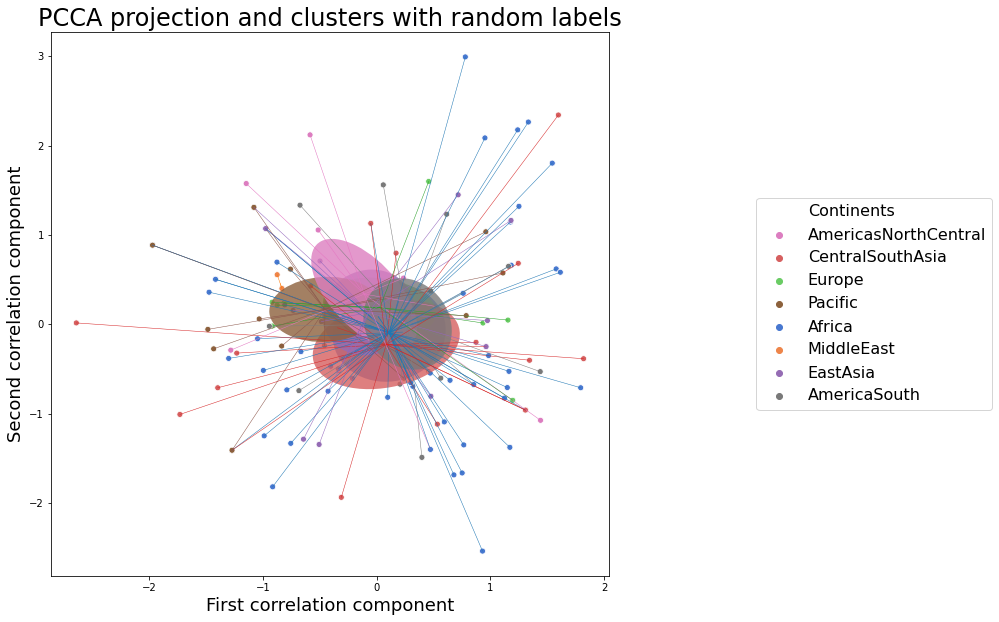

In [18]:
#@title PCCA projection of the data and their corresponding clusters with random sort of the continent labels
fig, ax = plt.subplots(figsize=(10, 10))

continents_unique_randomsort, ind = np.unique(continents_randomsort, return_index=True)
continents_unique_randomsort = continents_unique_randomsort[np.argsort(ind)] # to preserve its original order

# Plot a line joining each point to the center of the cluster
for i,elements in enumerate(continents_randomsort): 
  tmp = phonemes_pcca_randomsort.loc[phonemes_pcca_randomsort['Continents'] == elements] # choose points in a particular cluster
  center_x = np.mean(tmp["C1"]) # find the x coordinate of the center
  center_y = np.mean(tmp["C2"]) # find the y coordinate of the center
  clr = sns.color_palette()[[j for j, x in enumerate(elements == continents_unique) if x][0]] # find the color corresponding to the cluster
  plt.plot([center_x, phonemes_pcca_randomsort['C1'][i]], [center_y, phonemes_pcca_randomsort['C2'][i]], linewidth=.5, color = clr) # plot each line

# Plot each ellipse cluster
u = np.array([1,0])
for i,elements in enumerate(continents_unique):

  # Take the data from a continent (2-D coordinates of the points) 
  tmp = phonemes_pcca_randomsort.loc[phonemes_pcca_randomsort['Continents'] == elements]

  # Compute the center of the ellipse
  center_x = np.mean(tmp["C1"])
  center_y = np.mean(tmp["C2"])
  clr = sns.color_palette("muted")[[j for j, x in enumerate(elements == continents_unique) if x][0]]

  # Do PCA on the points to find the directions of maximal variance
  pca = PCA()
  pca.fit(tmp.drop("Continents", axis = 1))

  # Find the variance on each of those directions, as well as the directions
  size = pca.explained_variance_

  if pca.components_[0][1] < 0:
    v[1] = abs(pca.components_[0][1])
    v[0] = -1*pca.components_[0][0]
  else:
    v = pca.components_[0]
  c = np.dot(u,v)/np.linalg.norm(v)
  ang = np.arccos(c)*180/np.pi

  # Draw an elipse with that orientation
  ellipse = Ellipse(xy=(center_x, center_y), width = np.sqrt(size[0]), height = np.sqrt(size[1]), angle = ang, edgecolor='None', fc=clr, alpha = 0.8)
  ax.add_patch(ellipse)

# Plot each point in the CCA projection 
clr = []
for i,elements in enumerate(continents_unique_randomsort):
  clr.append(sns.color_palette("muted")[[j for j, x in enumerate(elements == continents_unique) if x][0]])

ax = sns.scatterplot(phonemes_pcca_randomsort['C1'], phonemes_pcca_randomsort['C2'], hue = phonemes_pcca_randomsort['Continents'], sizes = 15, palette = clr)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize = 16)

title2 = ax.set_title("PCCA projection and clusters with random labels", fontsize=24)
xlabel = ax.set_xlabel("First correlation component", fontsize = 18)
ylabel = ax.set_ylabel("Second correlation component", fontsize = 18)
plt.savefig('pcca_random_sort.pdf')

This figure is the same representation as the previous one, with the only difference that now the labels of the continent are randomly assigned to the languages. This was done to rule out overfitting, and indeed after repeating this random sorting several times, no pattern was found and all the languages appear merged together. We have therefore validated that there was no overfitting in the previous analysis. 

### Validation 2: leave-one-out

We perform a standard leave-one-out cross-validation just as described in described in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841). We perform the PCCA analysis of data excluding one language at a time, and then we compute the projection of the left out language on the computed projection and store this value. We repeat this process for each of the languages in the dataset, and then we draw the resulting projection with all the leftout data. 

In [19]:
# Leave-one-out cross-validation
results_oneout = []
for i in range(0,len(continents)):

  # Exclude element i, where i goes from 1 to the number of languages (139)
  alleles_oneout = alleles.T.drop(i)
  phonemes_oneout = phonemes.T.drop(i)
  continents_oneout = np.delete(continents, i)
  phoneme_leftout = pd.DataFrame(phonemes[i]).T

  # Perform the exact same PCCA analysis as before
  pca = PCA()
  pca.fit(alleles_oneout)
  alleles_oneout_pca = pd.DataFrame(pca.transform(alleles_oneout))

  pca = PCA()
  pca.fit(phonemes_oneout)
  phonemes_oneout_pca = pd.DataFrame(pca.transform(phonemes_oneout))
  phoneme_leftout_pca = pd.DataFrame(pca.transform(phoneme_leftout))

  n_components = 2;
  cca = CCA(n_components)

  alleles_oneout_pc = alleles_oneout_pca.iloc[:,0:2]
  phonemes_oneout_pc = phonemes_oneout_pca.iloc[:,0:10]
  phoneme_leftout_pc = phoneme_leftout_pca.iloc[:,0:10]

  cca.fit(phonemes_oneout_pc,alleles_oneout_pc)

  # Project the left out row into the new projection
  phoneme_leftout_projection = cca.transform(phoneme_leftout_pc)

  # Store this projected vector into a matrix
  results_oneout.append(phoneme_leftout_projection[0])

# Collect all the left-out projections into a dataframe
validation_oneout = pd.DataFrame(results_oneout)
validation_oneout['Continents'] = continents
validation_oneout .columns = ['C1','C2','Continents']

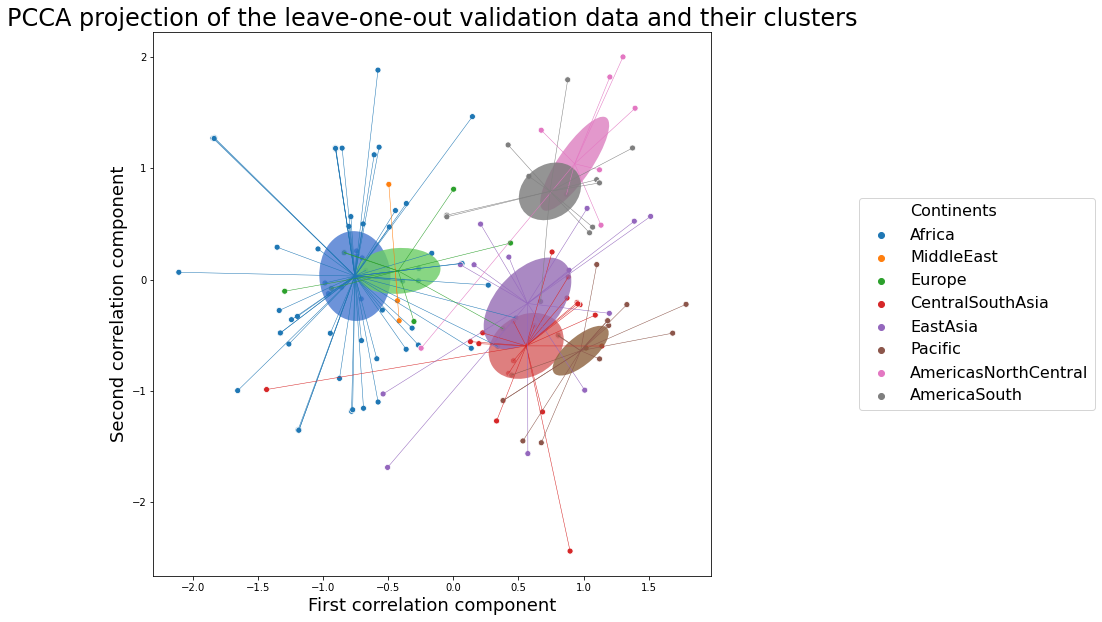

In [20]:
#@title PCCA projection of the leave-one-out cross-validation data and their corresponding clusters 
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each point in the CCA projection 
ax = sns.scatterplot(validation_oneout['C1'], validation_oneout['C2'], hue = validation_oneout['Continents'], sizes = 15)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize = 16)

# Plot a line joining each point to the center of the cluster
for i,elements in enumerate(continents): 
  tmp = validation_oneout.loc[validation_oneout['Continents'] == elements] # choose points in a particular cluster
  center_x = np.mean(tmp["C1"]) # find the x coordinate of the center
  center_y = np.mean(tmp["C2"]) # find the y coordinate of the center
  clr = sns.color_palette()[[j for j, x in enumerate(elements == continents_unique) if x][0]] # find the color corresponding to the cluster
  plt.plot([center_x, validation_oneout['C1'][i]], [center_y, validation_oneout['C2'][i]], linewidth=.5, color = clr) # plot each line

# Plot each ellipse cluster
u = np.array([1,0])
for elements in continents_unique:

  # Take the data from a continent (2-D coordinates of the points) 
  tmp = validation_oneout.loc[validation_oneout['Continents'] == elements]

  # Compute the center of the ellipse
  center_x = np.mean(tmp["C1"])
  center_y = np.mean(tmp["C2"])
  clr = sns.color_palette("muted")[[j for j, x in enumerate(elements == continents_unique) if x][0]]

  # Do PCA on the points to find the directions of maximal variance
  pca = PCA()
  pca.fit(tmp.drop("Continents", axis = 1))

  # Find the variance on each of those directions, as well as the directions
  size = pca.explained_variance_

  if pca.components_[0][1] < 0:
    v[1] = abs(pca.components_[0][1])
    v[0] = -1*pca.components_[0][0]
  else:
    v = pca.components_[0]
  c = np.dot(u,v)/np.linalg.norm(v)
  ang = np.arccos(c)*180/np.pi

  # Draw an elipse with that orientation
  ellipse = Ellipse(xy=(center_x, center_y), width = np.sqrt(size[0]), height = np.sqrt(size[1]), angle = ang, edgecolor='None', fc=clr, alpha = 0.8)
  ax.add_patch(ellipse)

title2 = ax.set_title("PCCA projection of the leave-one-out validation data and their clusters", fontsize=24)
xlabel = ax.set_xlabel("First correlation component", fontsize = 18)
ylabel = ax.set_ylabel("Second correlation component", fontsize = 18)
plt.savefig('pcca_cross_validation.pdf')

This figure is the same representation as the previous one, with the only difference that now the data being plotted is the projection of each of the left-out languages through the PCCA analysis. This figure appears very similar to the one obtained through the PCCA analysis, hence we have again validated our results from the PCCA analysis in the previous section. 


## PCCA Loadings: phoneme variablity accross regions

We can now try to answer the question: 

$\textit{Can we know where a language is spoken just by hearing how it sounds?}$ 

In particular, we can now look try to asses the phonemes responsible for the clustering. Notice that this is possible because the geography is already encoded through the alleles (and hence incorporated via the CCA projection), which allows for the geographic structure to show up without the need of a procrustes analysis. This allows us to maintain axes that are meaningful for the phonemic information, and which can be projected back from the PCCA space into the phonemic space. We will ultimately find the phonemes that are responsible for the clustering and that differenciate languages accross regions. 

In order to figure out what phonemes are responsible of the clustering we look at the loadings. In order to find the corresponding phonemes, we need to combine the loadings from CCA with the loadings from the PCA. In particular, the algebra goes as follows:

Let us call $y$ the base of vectors from PCA, and $z$ the base of vectors from CCA. $x$ represents the standard base in which the measurements were taken. Then:

$$y_i = \sum_{k=1}^{M}p^i_k x_k$$
$$z_j = \sum_{k=1}^{N}c^j_k y_k,$$
where $p$ are the loadings from PCA and $c$ are the loadings from CCA. Hence, if we want to find the loadings that relate $z$ to $x$, $\sum_{k=1}^{N}c^j_k p_i^k$ is the loading in each vector $z_j$ for each $x_i$.

We can compute this for all the vectors in matrix form as:

$$
\begin{bmatrix} c^1_1 & \dots & c^1_{10} \\
                \vdots & & \vdots \\
                c^{10}_1 & \dots & c^{10}_{10}
\end{bmatrix}
\begin{bmatrix} p_{1}^{1} & \dots & p^1_{728} \\
                \vdots & & \vdots \\
                p_{1}^{10} & \dots & p^{10}_{728}
\end{bmatrix}
$$

This operation is computed bellow and stored in phonemes_loadings.

In [21]:
phonemes_loadings = np.abs(phonemes_pca_loadings.iloc[:,0:10].dot(phonemes_cca_loadings))

We choose the number of phonemes responsible for the clustering based on the percentage of explained variance that they contribute to, first for the x-axis and then for the y-axis.

### For the x-axis:

Here, we are trying to find the phonemes that cause the clustering along the first correlation component, i.e., the x-axis. These are the phonemes that mostly distinguish languages in Europe, Africa and Middle East from the rest of the continents. We start by finding how many phonemes might be relevant in that distinction by looking at the explained variance of the loadings.

In [22]:
# Find loadings accross x-axis
phonemes_loadings_sorted_xaxis = phonemes_loadings[0].sort_values(ascending = False)
phonemes_variance_xaxis = phonemes_loadings_sorted_xaxis/np.sum(phonemes_loadings_sorted_xaxis) * 100

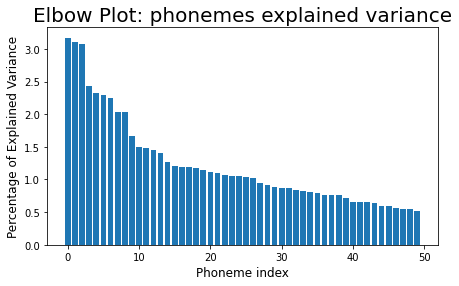

In [23]:
#@title Elbow plot to visualize contribution of each phoneme to the explained variance
fig, ax = plt.subplots(figsize=(7, 4))

upper_limit = 50
plt.bar(range(0,len(phonemes_variance_xaxis[0:upper_limit])), phonemes_variance_xaxis[0:upper_limit])

plt.ylabel('Percentage of Explained Variance', fontsize = 12)
plt.xlabel('Phoneme index', fontsize = 12 )
plt.title('Elbow Plot: phonemes explained variance', fontsize = 20)
plt.show()

We decide to choose the first 9 phonemes, which together contribute more than 20% to the explained variance. Hence, the phonemes that are responsible for the majority of the clustering along the x-axis are as follows: 

In [24]:
phonemes_x= list(phonemes_loadings_sorted_xaxis[0:9].index)
print(phonemes_x)

['n˜', 'f', 'ɔ', 'ᴺc', 'w', 'd', 'ɛ', 'b', 'ɡ']


To get an intuition of the obtained result, we perform the following sanity check where we evaluate the incidence of each of the found relevant phonemes in the given languages with the following bar plot. 

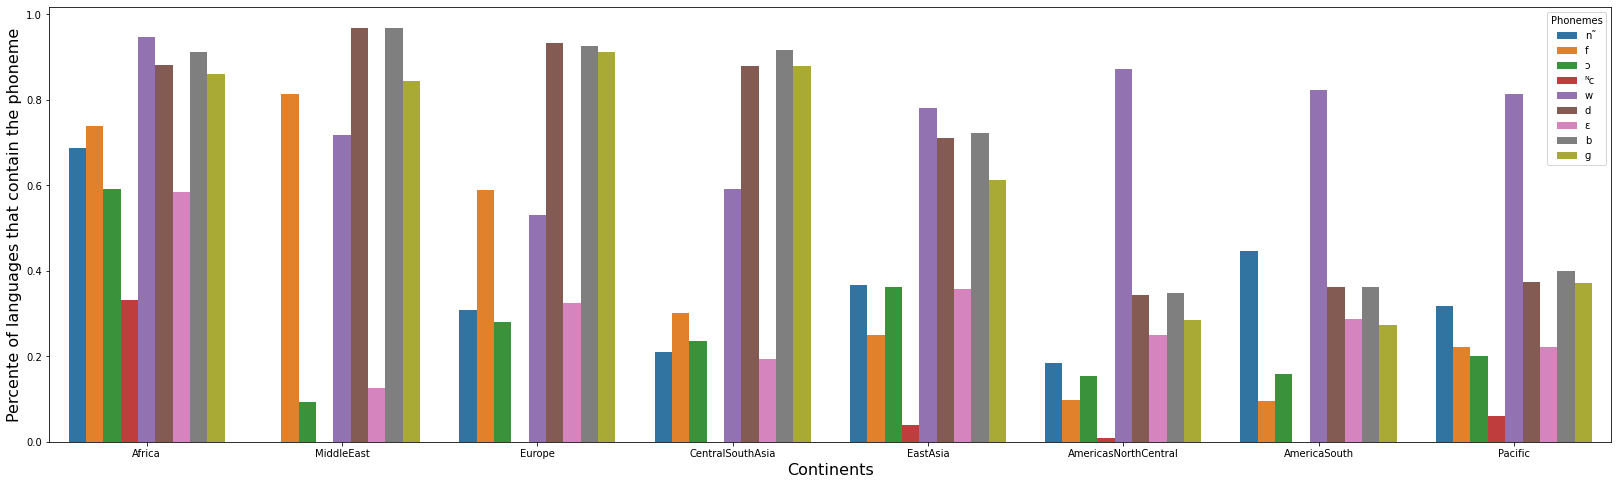

In [25]:
#@title Presence of each of the relevant phonemes along the first correlation component in the languages of each of the contients
phonemes_x_index = np.empty(len(phonemes_x))

for i,phoneme in enumerate(phonemes_x):
  phonemes_x_index[i] = phonemes_info_paper[phonemes_info_paper[1] == phoneme][0]-1

languages_x = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_x_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_x)):
    languages = languages_info_paper[languages_info_paper[phonemes_x_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_x[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_x_tmp.loc[i] = addition
  languages_x = languages_x.append(languages_x_tmp, ignore_index = True)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(28,8))
ax = sns.barplot(data = languages_x,x ='Continents', y ='Languages', hue = 'Phonemes')
xlabel = ax.set_xlabel("Continents", fontsize = 16)
ylabel = ax.set_ylabel("Percente of languages that contain the phoneme", fontsize = 16)
plt.savefig('sanity_check_x.pdf')

In this figure we would like to observe a qualitative difference between Africa, Europe and Middle East from the rest of the regions. We can see how the orange, purple, brown, light green and grey bars are higher in these regions and exhibit a unique combination that does not appear in the other regions. The blue, red and green bars are exceptionally high in the african languages, which might explain its position in the plot, all the way to the left. We can also see how the Americas have a very similar phonemic profile, which explains their proximity. This profile is also very similar to the pacific languages, as well as East Asia, which might explain why they appear all the way to the right in the PCCA diagram. 

### For the y-axis:

Now, we are trying to find the phonemes that cause the clustering along the second correlation component, i.e., the y-axis. These are the phonemes that mostly distinguish languages in the Americas from Europe, Africa, Middle East and East Asia, as well as from Central South Asia and the Pacific regions. Again, we start by finding how many phonemes might be relevant in that distinction by looking at the explained variance of the loadings.

In [26]:
# Find loadings accross y-axis
phonemes_loadings_sorted_yaxis = phonemes_loadings[1].sort_values(ascending = False)
phonemes_variance_yaxis = phonemes_loadings_sorted_yaxis/np.sum(phonemes_loadings_sorted_yaxis) * 100

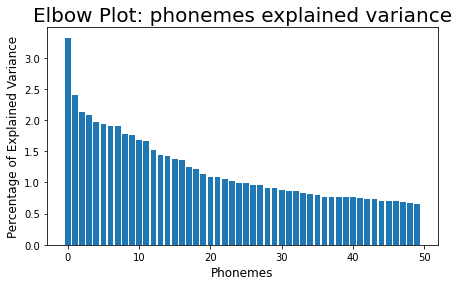

In [27]:
#@title Elbow plot to visualize contribution of each phoneme to the explained variance
upper_limit = 50

fig, ax = plt.subplots(figsize=(7, 4))
plt.bar(range(0,len(phonemes_variance_yaxis[0:upper_limit])), phonemes_variance_yaxis[0:upper_limit])

plt.ylabel('Percentage of Explained Variance', fontsize = 12)
plt.xlabel('Phonemes', fontsize = 12)
plt.title('Elbow Plot: phonemes explained variance', fontsize = 20)
plt.show()

This time we also choose the first 9 phonemes, which together contribute once again to more than 20% to the explained variance. Hence, the phonemes that are responsible for the majority of the clustering along the y-axis are as follows:

In [28]:
phonemes_y = list(phonemes_loadings_sorted_yaxis[0:9].index)
print(phonemes_y)

['ʔ', 'š', 'ɨ', 'ŋ', 'b', 'w', 'kˀ', 'č', 'vː']


To get an intuition of the obtained result, we perform the following sanity check where we evaluate the incidence of each of the found relevant phonemes in the given languages with the following bar plot. 

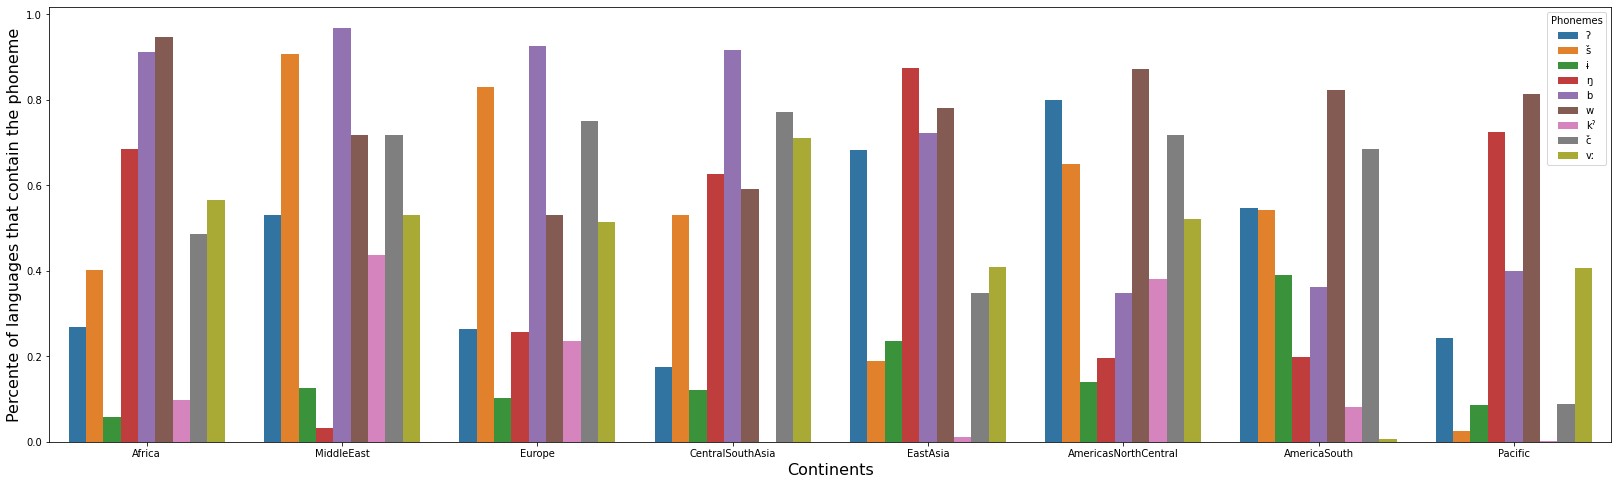

In [29]:
#@title Presence of each of the relevant phonemes along the second correlation component in the languages of each of the contients
phonemes_y_index = np.empty(len(phonemes_y))

for i,phoneme in enumerate(phonemes_y):
  phonemes_y_index[i] = phonemes_info_paper[phonemes_info_paper[1] == phoneme][0]-1

languages_y = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_y_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_y)):
    languages = languages_info_paper[languages_info_paper[phonemes_y_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_y[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_y_tmp.loc[i] = addition
  languages_y = languages_y.append(languages_y_tmp, ignore_index = True)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(28,8))
sns.barplot(data = languages_y,x ='Continents', y ='Languages', hue = 'Phonemes')
xlabel = ax.set_xlabel("Continents", fontsize = 16)
ylabel = ax.set_ylabel("Percente of languages that contain the phoneme", fontsize = 16)
plt.savefig('sanity_check_y.pdf')

In this figure we would like to observe a qualitative difference between the Americas, Central South Asia and the Pacific and the rest of the continents. In this diagram is a little harder to see, but we can see how they are the only languages with such a high prevalence of blue, orange, brown and grey phonemes and a very low purple one. On the other hand, Pacific and Central South Asia are the only regions lacking the pink bar completely, and in particular Pacific has a very unique profile with such a low amount of both orange and grey. This might explain their relative positions in the PCCA diagram. 

## Frequency of the phonemes found


Here we analyze the frequency of apearance of the phonemes in the different languages and compare that with the explained variance that they present in each of the axis in the PCCA projection. We exclude the phonemes that do not appear in each of the 139 languages studied. 

In [30]:
# Compute the frequency of apearance of each phonemes
phonemes_frequency = phonemes.mean(axis=1)

In [31]:
# Order the array of frequencies to match the the order of the array of explained variance. To do that we use a common criterion of alphabetical order for the phonemes
aux = np.array(phonemes_frequency.index)
phonemes_frequency_sorted = pd.DataFrame(phonemes_frequency.take(np.argsort(aux)))

# Do the same for the variance accross the x axis
aux = np.array(phonemes_variance_xaxis.index)
phonemes_variance_xaxis_sorted = phonemes_variance_xaxis.take(np.argsort(aux))

# Do the same for the variance accross the y axis
aux = np.array(phonemes_variance_yaxis.index)
phonemes_variance_yaxis_sorted = phonemes_variance_yaxis.take(np.argsort(aux))

In [32]:
# Exclude the phonemes that do not appear in any of the 139 languages (frequency = 0)
indices_of_phonemes_to_keep = phonemes_frequency_sorted[0] != 0

phonemes_frequency_sorted_nozeros = phonemes_frequency_sorted.loc[indices_of_phonemes_to_keep][0]
phonemes_variance_xaxis_sorted_nozeros = phonemes_variance_xaxis_sorted.loc[indices_of_phonemes_to_keep]
phonemes_variance_yaxis_sorted_nozeros = phonemes_variance_yaxis_sorted.loc[indices_of_phonemes_to_keep]

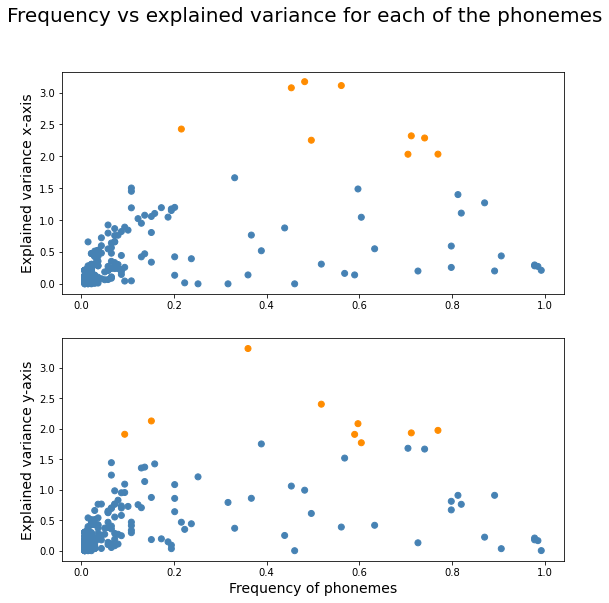

In [41]:
#@title Frequency vs explained variace accross each axis for each of the phoenemes. The ones explaining the most variance (and shown in the section above) are colored in orange. 

# Plot the 9 phonemes with most explained variance accross the x-axis and color them with a different color
plt_col_xaxis = []
for i in range(len(phonemes_variance_xaxis_sorted_nozeros)):
  if phonemes_variance_xaxis_sorted_nozeros.index[i] in phonemes_variance_xaxis[0:9].index.tolist():
    plt_col_xaxis += ["darkorange"]
  else:
    plt_col_xaxis += ["steelblue"]

# Plot the 9 phonemes with most explained variance accross the x-axis and color them with a different color
plt_col_yaxis = []
for i in range(len(phonemes_variance_xaxis_sorted_nozeros)):
  if phonemes_variance_yaxis_sorted_nozeros.index[i] in phonemes_variance_yaxis[0:9].index.tolist():
    plt_col_yaxis += ["darkorange"]
  else:
    plt_col_yaxis += ["steelblue"]

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (9,9))
ax1.scatter(phonemes_frequency_sorted_nozeros, phonemes_variance_xaxis_sorted_nozeros, c = plt_col_xaxis)
ax2.scatter(phonemes_frequency_sorted_nozeros, phonemes_variance_yaxis_sorted_nozeros, c = plt_col_yaxis)

# Labels and title
xlab = ax2.set_xlabel("Frequency of phonemes", fontsize = 14 )
ylab1 = ax1.set_ylabel("Explained variance x-axis", fontsize = 14 )
ylab2 = ax2.set_ylabel("Explained variance y-axis", fontsize = 14 )
tit = plt.suptitle("Frequency vs explained variance for each of the phonemes", fontsize = 20)
plt.savefig('freq_explvar.pdf')